In [1]:
%matplotlib notebook
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.gaussian_process.kernels import PairwiseKernel, RBF, Product, ConstantKernel as C, RationalQuadratic as RQ, Matern, WhiteKernel
from sklearn.metrics import r2_score

import numpy as np
from joblib import dump, load
import os
#from schwimmbad import MPIPool
import matplotlib
from matplotlib import pyplot as plt

In [2]:
#load in input training data
emsp_train = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\em_sample_points200.npy") #set of sample parameter
#load in output training data
gal_Mstar_train = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_Mstar_200.npy")
gal_FeH_mean_train = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_mean_200.npy")
gal_FeH_std_train = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_std_200.npy")

#load in input testing data
emsp_test = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\em_sample_points10000.npy") #set of sample parameter
#load in output testing data
gal_Mstar_test = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_Mstar_10000.npy")
gal_FeH_mean_test = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_mean_10000.npy")
gal_FeH_std_test = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_std_10000.npy")

In [3]:
print(emsp_train[0])

[1.20375523e+00 2.39365600e+00 2.38613329e-01 6.71041206e-02
 4.42006265e-01 6.62337548e-01 1.53696871e+00 2.92568785e-01
 4.62234461e-01 1.05880499e-03]


In [ ]:
sigma_train = np.zeros(len(gal_Mstar_train[0])) 
em_Mstar = []
em_Mstar_pred = np.zeros([len(gal_Mstar_test),len(gal_Mstar_test[0])])
em_Mstar_pred_std = np.zeros([len(gal_Mstar_test),len(gal_Mstar_test[0])])

#Stellar mass emulators
for i in range(len(gal_Mstar_train[0])):
    sigma_train[i] = np.std(gal_Mstar_train[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train[i]**2) * RBF() * C(sigma_train[i]**2) * RQ() 
    em_Mstar.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_Mstar[i].fit(emsp_train,gal_Mstar_train[:,i])
    em_Mstar_pred[:,i], em_Mstar_pred_std[:,i] = em_Mstar[i].predict(emsp_test, return_std = True)

In [ ]:
#test predictions
print(em_Mstar_pred_std.max())
for i in range(len(gal_Mstar_train[0])):
    print("Test sample " + str(i) + " : R^2 - "+ str(em_Mstar[i].score(emsp_test, gal_Mstar_test[:,i]))+ ", LML:" + str(em_Mstar[i].log_marginal_likelihood())) #Test R^2
    print(r2_score(gal_Mstar_test[:,i], em_Mstar_pred[:,i]))
    #print("Dataset sigma: " + str(sigma_train[0]) + " vs " + str(em_Mstar_pred_std[:,0]))
#print()

#print(em_Mstar)
#print(x.shape)
#print(emsp_train.shape)
#print(emsp_test.shape)
#print(em_Mstar.score(emsp_train, gal_Mstar_train)) #GP models inherently match all the sample points

In [ ]:
sigma_train = np.zeros(len(gal_FeH_mean_train[0]))
em_FeH_mean = []
em_FeH_mean_pred = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
em_FeH_mean_pred_std = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
#print(gal_FeH_mean_train[:,i].shape)

#Metallicity emulators                          
for i in range(len(gal_FeH_mean_train[0])):
    sigma_train[i] = np.std(gal_FeH_mean_train[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train[i]**2) * RBF() * PairwiseKernel()
    em_FeH_mean.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_FeH_mean[i].fit(emsp_train,gal_FeH_mean_train[:,i])
    em_FeH_mean_pred[:,i], em_FeH_mean_pred_std[:,i] = em_FeH_mean[i].predict(emsp_test, return_std = True)

In [ ]:
r_2 = 0
for i in range((len(gal_FeH_mean_train[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i]))+ ", LML:" + str(em_FeH_mean[i].log_marginal_likelihood())) #Test R^2
    r_2 += em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i])

r_2 = r_2 / (len(gal_FeH_mean_train[0])-1)
print(r_2)

In [ ]:
#print(prev_R_score_F)
LML_cnt = 0
R_cnt = 0 
for i in range(len(gal_FeH_mean_train[0])):
    print("Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i])) + ", LML:" + str(em_FeH_mean[i].log_marginal_likelihood())) #Test R^2
    if em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i])-prev_R_score_F[i] > 0:
        print("R^2 increase")
        R_cnt += 1
    else:
        print("R^2 decrease")
    if em_FeH_mean[i].log_marginal_likelihood()-prev_LML_score_F[i] > 0:
        print("LML increase")
        LML_cnt += 1 
    else:
        print("LML decrease")
    #print((em_FeH_mean_pred[:,20]-gal_FeH_mean_test[:,20]).mean())
print(R_cnt)
print(LML_cnt)

In [ ]:
prev_R_score_F = []
prev_LML_score_F = []
for i in range(len(gal_Mstar_train[0])):
    prev_R_score_F.append(em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i]))
    prev_LML_score_F.append(em_FeH_mean[i].log_marginal_likelihood())

In [ ]:
'''
#FeH_std emulator
kern = Matern()
# to set number of jobs to the number of cores, use n_jobs=-1
em_FeH_std = MultiOutputRegressor(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
em_FeH_std.fit(emsp_train,gal_FeH_std_train)
#test prediction
em_FeH_std_pred = em_FeH_std.predict(emsp_test)

print(em_FeH_std.score(emsp_train, gal_FeH_std_train)) #GP models inherently match all the sample points
print(em_FeH_std.score(emsp_test,gal_FeH_std_test)) #R^2
'''

In [ ]:
#%matplotlib nbagg

mean = em_FeH_mean_pred_std
Mstar = em_Mstar_pred_std

#print(mean[0].shape)

j = 0
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')
for i in range(4):
    for k in range(5):
        ax[i, k].errorbar(gal_Mstar_test[j][:-1], gal_FeH_mean_test[j][:-1], fmt='o',color ='steelblue', label='GAMMA Sub-trees')
        ax[i, k].errorbar(gal_Mstar_test[j][-1], gal_FeH_mean_test[j][-1], fmt='o', color = 'firebrick',label='GAMMA Host-tree')
        ax[i, k].errorbar(em_Mstar_pred[j][:-1], em_FeH_mean_pred[j][:-1], xerr = 1.96*Mstar[j][:-1], yerr=1.96*mean[j][:-1], fmt='o', color = 'goldenrod', label='Emulated Sub-trees')
        ax[i, k].errorbar(em_Mstar_pred[j][-1], em_FeH_mean_pred[j][-1], xerr = 1.96*Mstar[j][-1], yerr=1.96*mean[j][-1], fmt='o', color = 'lightcoral', label='Emulated Host-tree')
        ax[i, k].set_xscale('log')
        j += 1


plt.legend(loc='right')
#plt.xscale('log')
fig.text(0.5, 0.03, '$M_\star$ [M$_\odot$]', ha='center', va='center')
fig.text(0.06, 0.5, '[Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('Metallicity [Fe/H] vs Stellar Mass [M$_\odot$]')
plt.legend(bbox_to_anchor=(-2.5,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

In [ ]:
print(em_Mstar_pred[0,:])

In [ ]:
#%matplotlib nbagg

j = 10
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')
for i in range(4):
    for k in range(5):
        ax[i, k].errorbar(gal_Mstar_test[j][:-1], gal_FeH_mean_test[j][:-1], fmt='o',color ='steelblue', label='Dwarf Galaxy (GAMMA)')
        ax[i, k].errorbar(gal_Mstar_test[j][-1], gal_FeH_mean_test[j][-1], fmt='o', color = 'firebrick',label='GAMMA Host-tree')
        ax[i, k].errorbar(em_Mstar_pred[j][:-1], em_FeH_mean_pred[j][:-1], xerr = Mstar[j][:-1], yerr=mean[j][:-1], fmt='o', color = 'goldenrod', label='Dwarf Galaxy (Emulator)')
        ax[i, k].errorbar(em_Mstar_pred[j][-1], em_FeH_mean_pred[j][-1], xerr = Mstar[j][-1], yerr=mean[j][-1], fmt='o', color = 'lightcoral', label='Emulated Host-tree')
        ax[i, k].set_xscale('log')
        j += 1


plt.legend(loc='right')
#plt.xscale('log')
fig.text(0.5, 0.03, '$M_\star$ [M$_\odot$]', ha='center', va='center')
fig.text(0.06, 0.5, '[Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('Metallicity [Fe/H] vs Stellar Mass [M$_\odot$]', x=.5, y=.98)
plt.legend(bbox_to_anchor=(-2,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

In [ ]:
#%matplotlib nbagg

j = 40
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row')
for i in range(2):
    for k in range(5):
        ax[i, k].errorbar(gal_Mstar_test[j][:-1], gal_FeH_mean_test[j][:-1], fmt='o',color ='steelblue', label='Dwarf Galaxy (GAMMA)')
        ax[i, k].errorbar(gal_Mstar_test[j][-1], gal_FeH_mean_test[j][-1], fmt='o', color = 'firebrick',label='GAMMA Host-tree')
        ax[i, k].errorbar(em_Mstar_pred[j][:-1], em_FeH_mean_pred[j][:-1], xerr = Mstar[j][:-1], yerr=mean[j][:-1], fmt='o', color = 'goldenrod', label='Galaxy (Emulated)')
        ax[i, k].errorbar(em_Mstar_pred[j][-1], em_FeH_mean_pred[j][-1], xerr = Mstar[j][-1], yerr=mean[j][-1], fmt='o', color = 'lightcoral', label='Emulated Host-tree')
        ax[i, k].set_xscale('log')
        ax[i, k].set_xlim([7e5,3*10e9])
        
        j += 1


plt.legend(loc='best')
#plt.xscale('log')
fig.text(0.5, 0.03, 'Stellar Mass - log([M$_\odot$])', ha='center', va='center')
fig.text(0.06, 0.5, 'Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('GAMMA-EM Results (10 Parameter Sets)')
plt.legend(bbox_to_anchor=(-2,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

In [ ]:
%matplotlib notebook

#standard deviation exploration

em_combo_std = em_FeH_mean_pred_std * em_Mstar_pred_std

from scipy import stats
j = 1
for i in range(len(em_FeH_mean_pred_std[0])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(emsp_test[:,j],em_combo_std[:,i])
    line = slope*emsp_test[:,j]+intercept
    plt.plot(emsp_test[:,j], line)
    plt.scatter(emsp_test[:,j],em_combo_std[:,i], s=1)

In [ ]:
%matplotlib notebook

#standard deviation exploration

em_combo_std_2 = em_FeH_mean_pred_std_2 * em_Mstar_pred_std_2

from scipy import stats
j = 1
for i in range(len(em_FeH_mean_pred_std_2[0])):
    slope, intercept, r_value, p_value, std_err = stats.linregress(emsp_test[:,j],em_combo_std[:,i])
    line = slope*emsp_test[:,j]+intercept
    plt.plot(emsp_test[:,j], line)
    #plt.scatter(emsp_test_2[:,1],em_combo_std_2[:,i], s=1)

## 2nd generation of emulator

In [15]:
sigma_train = np.zeros(len(gal_Mstar_train[0])) 
em_Mstar = []
log_em_Mstar_pred = np.zeros([len(gal_Mstar_test),len(gal_Mstar_test[0])])
log_em_Mstar_pred_std = np.zeros([len(gal_Mstar_test),len(gal_Mstar_test[0])])
log_gal_Mstar_train = np.log10(gal_Mstar_train)

#Stellar mass emulators
for i in range(len(gal_Mstar_train[0])):
    sigma_train[i] = np.log10(np.std(gal_Mstar_train[:,i]))
    #print(sigma_train[i])
    kern = C(sigma_train[i]**2) * RBF() * Matern() + WhiteKernel() 
    em_Mstar.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_Mstar[i].fit(emsp_train,log_gal_Mstar_train[:,i])
    log_em_Mstar_pred[:,i], log_em_Mstar_pred_std[:,i] = em_Mstar[i].predict(emsp_test, return_std = True)


In [16]:
sigma_train = np.zeros(len(gal_FeH_mean_train[0]))
em_FeH_mean = []
em_FeH_mean_pred = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
em_FeH_mean_pred_std = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
#print(gal_FeH_mean_train[:,i].shape)

#Metallicity emulators                          
for i in range(len(gal_FeH_mean_train[0])):
    sigma_train[i] = np.std(gal_FeH_mean_train[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train[i]**2) * RBF() * PairwiseKernel()
    em_FeH_mean.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_FeH_mean[i].fit(emsp_train,gal_FeH_mean_train[:,i])
    em_FeH_mean_pred[:,i], em_FeH_mean_pred_std[:,i] = em_FeH_mean[i].predict(emsp_test, return_std = True)

In [17]:
em_combo_std = log_em_Mstar_pred_std*em_FeH_mean_pred_std

var_index = np.arange(0, 10000, 1).reshape(10000,1)
indexed_combo_std = np.append(em_combo_std, var_index, axis = 1)
indexed_emsp = np.append(emsp_test, var_index, axis = 1)

In [18]:
print(em_FeH_mean_pred_std)

[[0.25722116 0.50538029 0.62118802 ... 0.28965465 0.41435596 0.24210647]
 [0.55854804 1.0033131  1.17235745 ... 0.60225624 0.87534724 0.41496038]
 [0.14169544 0.24207718 0.27809039 ... 0.14856653 0.21796064 0.09696668]
 ...
 [0.36562038 0.68246518 0.81736564 ... 0.40133332 0.57943068 0.3054097 ]
 [0.32073755 0.55427617 0.63573928 ... 0.33897654 0.49613724 0.21760491]
 [0.24926923 0.46424529 0.5556483  ... 0.27324718 0.39466894 0.20749591]]


In [19]:
%matplotlib notebook

top_index = np.zeros([22, 75])

for i in range(len(indexed_combo_std[0])-1):
    x = indexed_combo_std[indexed_combo_std[:,i].argsort()] #sorts the given column 
    top_index[i] = x[-75:,-1].T #gets the largest combined std dev in each column
        
#print(top_index)
top, counts = np.unique(top_index, return_counts=True) #top is the array of the row index of emsp_test points that need to be added to the emulator
print(top)

[ 179.  472.  513.  571.  591.  923.  970.  994. 1194. 1285. 1369. 1462.
 1547. 1567. 1743. 1783. 1910. 1962. 1969. 2246. 2297. 2403. 2669. 2691.
 2735. 2763. 3175. 3418. 3684. 3821. 3844. 3846. 4018. 4442. 4473. 4510.
 4629. 4782. 4910. 4948. 4963. 5062. 5065. 5967. 6026. 6055. 6439. 6529.
 6604. 6700. 6710. 6734. 6883. 6992. 7034. 7112. 7122. 7233. 7241. 7269.
 7499. 7530. 7573. 7574. 7749. 7751. 7777. 7873. 7934. 8012. 8222. 8275.
 8312. 8315. 8558. 8697. 8792. 9029. 9096. 9131. 9151. 9207. 9401. 9517.
 9904. 9926.]


In [20]:
emsp_train_adds = np.zeros([len(top), len(emsp_test[0])]) #points to add to the training data
gal_Mstar_train_adds = np.zeros([len(top), len(gal_Mstar_test[0])])
gal_FeH_mean_train_adds = np.zeros([len(top), len(gal_FeH_mean_test[0])])
                                 
for i in range(len(top)):
    index = int(top[i])
    #print(index)
    emsp_train_adds[i] = emsp_test[index]
    gal_Mstar_train_adds[i] = gal_Mstar_test[index]
    gal_FeH_mean_train_adds[i] = gal_FeH_mean_test[index]
print(emsp_train_adds.shape)

(86, 10)


In [21]:
#add training points
emsp_train_2 = np.append(emsp_train, emsp_train_adds, axis = 0)
gal_Mstar_train_2 = np.append(gal_Mstar_train, gal_Mstar_train_adds, axis = 0)
gal_FeH_mean_train_2 = np.append(gal_FeH_mean_train, gal_FeH_mean_train_adds, axis = 0)
print(emsp_train_2.shape)
print(gal_Mstar_train_2.shape)
print(gal_FeH_mean_train_2.shape)

#import new test points
emsp_test_2 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\em_sample_points10000_2.npy") #set of sample parameter
#load in output testing data
gal_Mstar_test_2 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_Mstar_10000_2.npy")
gal_FeH_mean_test_2 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_mean_10000_2.npy")
gal_FeH_std_test_2 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_std_10000_2.npy")

(286, 10)
(286, 22)
(286, 22)


<IPython.core.display.Javascript object>


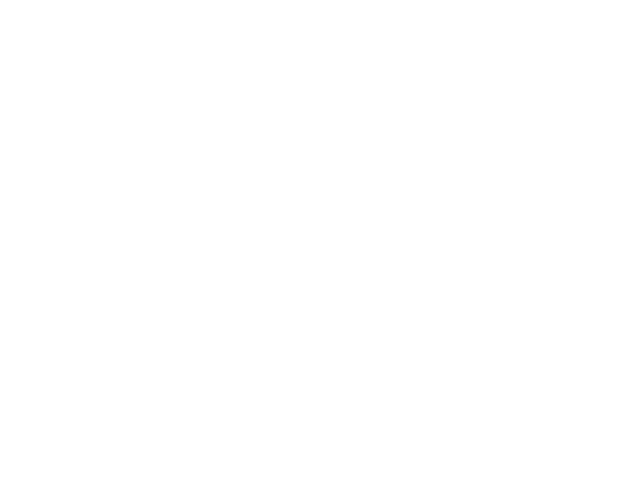

In [22]:
%matplotlib notebook
residuals_Mstar = np.log10(gal_Mstar_test_2) - log_em_Mstar_pred
for i in range(len(log_em_Mstar_pred_std[0])-1):
    plt.scatter(emsp_test[:,1],np.log10(gal_Mstar_test_2[:,5]), s=1)

In [23]:
#for comparison - 30 seconds for 10000
for i in range(len(gal_Mstar_train[0])):
    log_em_Mstar_pred[:,i], log_em_Mstar_pred_std[:,i] = em_Mstar[i].predict(emsp_test_2, return_std = True)
    
for i in range(len(gal_FeH_mean_train[0])):
    em_FeH_mean_pred[:,i], em_FeH_mean_pred_std[:,i] = em_FeH_mean[i].predict(emsp_test_2, return_std = True)

In [24]:
sigma_train_2 = np.zeros(len(gal_Mstar_train_2[0])) 
em_Mstar_2 = []
log_em_Mstar_pred_2 = np.zeros([len(gal_Mstar_test_2),len(gal_Mstar_test_2[0])])
log_em_Mstar_pred_std_2 = np.zeros([len(gal_Mstar_test_2),len(gal_Mstar_test_2[0])])
log_gal_Mstar_train_2 = np.log10(gal_Mstar_train_2)
#print(log_gal_Mstar_train_2)

#Stellar mass emulators
for i in range(len(gal_Mstar_train_2[0])):
    sigma_train_2[i] = np.log10(np.std(gal_Mstar_train_2[:,i]))
    #print(sigma_train[i])
    kern = C(sigma_train_2[i]**2) * RBF() * Matern() + WhiteKernel()
    em_Mstar_2.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_Mstar_2[i].fit(emsp_train_2,log_gal_Mstar_train_2[:,i])
    log_em_Mstar_pred_2[:,i], log_em_Mstar_pred_std_2[:,i] = em_Mstar_2[i].predict(emsp_test_2, return_std = True)

In [25]:
print(np.power(10,log_em_Mstar_pred_2[:,5]))
print(gal_Mstar_test_2[:,5])

[5.80253096e+07 7.26418203e+07 1.32537561e+08 ... 4.02372196e+06
 2.49931575e+07 5.03867707e+06]
[6.41745839e+07 1.01844673e+08 1.11050241e+08 ... 4.04902241e+06
 3.01820892e+07 2.99627621e+05]


In [26]:
#R^2 check against 1st gen emulator
for i in range(len(gal_Mstar_train_2[0])):
    print("1. Test sample " + str(i) + " : R^2 - "+ str(r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred[:,i]))+ ", LML:" + str(em_Mstar[i].log_marginal_likelihood())) #Test R^2
    print("2. Test sample " + str(i) + " : R^2 - "+ str(r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred_2[:,i]))+ ", LML:" + str(em_Mstar_2[i].log_marginal_likelihood())) #Test R^2
    #print("2. Test sample " + str(i) + " : R^2 - "+ str(em_Mstar_2[i].score(emsp_test_2,np.log10(gal_Mstar_test_2[:,i])))+ ", LML:" + str(em_Mstar_2[i].log_marginal_likelihood())) #Test R^2
    #print("Test sample " + str(i) + " : R^2 - " + str(em_Mstar_2[i].score(emsp_test_2, gal_Mstar_test_2[:,i])- em_Mstar[i].score(emsp_test, gal_Mstar_test[:,i])))
    #print("Test sample " + str(i) + " : LML difference (Bayes factor) - " + str(em_Mstar_2[i].log_marginal_likelihood()-em_Mstar[i].log_marginal_likelihood()))

1. Test sample 0 : R^2 - 0.7768581592376463, LML:-50.07864221926093
2. Test sample 0 : R^2 - 0.8080595610055264, LML:-57.49556150267466
1. Test sample 1 : R^2 - 0.7428079695170708, LML:-116.12390189732497
2. Test sample 1 : R^2 - 0.7801832111800572, LML:-148.2681005199426
1. Test sample 2 : R^2 - 0.7615792556192983, LML:-142.8608704556881
2. Test sample 2 : R^2 - 0.800514575301962, LML:-178.99743944602568
1. Test sample 3 : R^2 - 0.7782539423792161, LML:-115.8394773041621
2. Test sample 3 : R^2 - 0.8220191747407273, LML:-142.49098159904145
1. Test sample 4 : R^2 - 0.7704906604502048, LML:-138.99427201899994
2. Test sample 4 : R^2 - 0.8142376331341201, LML:-175.13632247215978
1. Test sample 5 : R^2 - 0.7646322600195065, LML:-139.80492839487485
2. Test sample 5 : R^2 - 0.8044043332906659, LML:-180.19827497102872
1. Test sample 6 : R^2 - 0.7949357391326841, LML:60.9697156547015
2. Test sample 6 : R^2 - 0.8431353901438325, LML:99.21017941748198
1. Test sample 7 : R^2 - 0.7952859467531199, 

In [27]:
r_2_1 = 0
for i in range((len(gal_Mstar_train_2[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred[:,i]))) #Test R^2
    r_2_1 += r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred[:,i])

r_2_1 = r_2_1 / (len(gal_Mstar_train_2[0])-1)

r_2_2 = 0
for i in range((len(gal_Mstar_train_2[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred_2[:,i]))) #Test R^2
    r_2_2 += r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred_2[:,i])

r_2_2 = r_2_2 / (len(gal_Mstar_train_2[0])-1)

print("R^2 of 1st gen: " + str(r_2_1))
print("R^2 of 2nd gen: " + str(r_2_2))

Test sample 0 : R^2 - 0.7768581592376463
Test sample 1 : R^2 - 0.7428079695170708
Test sample 2 : R^2 - 0.7615792556192983
Test sample 3 : R^2 - 0.7782539423792161
Test sample 4 : R^2 - 0.7704906604502048
Test sample 5 : R^2 - 0.7646322600195065
Test sample 6 : R^2 - 0.7949357391326841
Test sample 7 : R^2 - 0.7952859467531199
Test sample 8 : R^2 - 0.8053195615305858
Test sample 9 : R^2 - 0.7872388194878027
Test sample 10 : R^2 - 0.7571062348814938
Test sample 11 : R^2 - 0.7061618395454519
Test sample 12 : R^2 - 0.7357294838358779
Test sample 13 : R^2 - 0.6970910024544039
Test sample 14 : R^2 - 0.6585332553208381
Test sample 15 : R^2 - 0.803006871087251
Test sample 16 : R^2 - 0.6883210377948876
Test sample 17 : R^2 - 0.7760387404727289
Test sample 18 : R^2 - 0.7518799911565036
Test sample 19 : R^2 - 0.7611399616816261
Test sample 20 : R^2 - 0.744117974121588
Test sample 0 : R^2 - 0.8080595610055264
Test sample 1 : R^2 - 0.7801832111800572
Test sample 2 : R^2 - 0.800514575301962
Test sam

In [28]:
sigma_train_2 = np.zeros(len(gal_FeH_mean_train_2[0])) 
em_FeH_mean_2 = []
em_FeH_mean_pred_2 = np.zeros([len(gal_FeH_mean_test_2),len(gal_FeH_mean_test_2[0])])
em_FeH_mean_pred_std_2 = np.zeros([len(gal_FeH_mean_test_2),len(gal_FeH_mean_test_2[0])])

#Stellar mass emulators
for i in range(len(gal_FeH_mean_train_2[0])):
    sigma_train_2[i] = np.std(gal_FeH_mean_train_2[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train_2[i]**2) * RBF() * PairwiseKernel()
    em_FeH_mean_2.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_FeH_mean_2[i].fit(emsp_train_2,gal_FeH_mean_train_2[:,i])
    em_FeH_mean_pred_2[:,i], em_FeH_mean_pred_std_2[:,i] = em_FeH_mean_2[i].predict(emsp_test_2, return_std = True)

In [29]:
#R^2 check against 1st gen emulator
#for i in range(len(gal_FeH_mean_train_2[0])):
    #print("1. Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i]))+ ", LML:" + str(em_FeH_mean[i].log_marginal_likelihood())) #Test R^2
    #print("2. Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean_2[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i]))+ ", LML:" + str(em_FeH_mean_2[i].log_marginal_likelihood())) #Test R^2
    #print("Test sample " + str(i) + " : R^2 - " + str(em_FeH_mean_2[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i])- em_FeH_mean[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i])))
    #print("Test sample " + str(i) + " : LML difference (Bayes factor) - " + str(em_FeH_mean[i].log_marginal_likelihood()-em_FeH_mean_2[i].log_marginal_likelihood()))
    
r_2_1 = 0
for i in range((len(gal_FeH_mean_train_2[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_2[:,i], em_FeH_mean_pred[:,i]))) #Test R^2
    r_2_1 += r2_score(gal_FeH_mean_test_2[:,i], em_FeH_mean_pred[:,i])

r_2_1 = r_2_1 / (len(gal_FeH_mean_train_2[0])-1)

r_2_2 = 0
for i in range((len(gal_FeH_mean_train_2[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_2[:,i], em_FeH_mean_pred_2[:,i]))) #Test R^2
    r_2_2 += r2_score(gal_FeH_mean_test_2[:,i], em_FeH_mean_pred_2[:,i])
r_2_2 = r_2_2 / (len(gal_FeH_mean_train_2[0])-1)

print("R^2 of 1st gen: " + str(r_2_1))
print("R^2 of 2nd gen: " + str(r_2_2))

Test sample 0 : R^2 - 0.6555157512099545
Test sample 1 : R^2 - 0.49457895414598263
Test sample 2 : R^2 - 0.5777179617705934
Test sample 3 : R^2 - 0.6702500620351076
Test sample 4 : R^2 - 0.7656882730039132
Test sample 5 : R^2 - 0.6317130523190839
Test sample 6 : R^2 - 0.3098758402376718
Test sample 7 : R^2 - 0.7428456768855937
Test sample 8 : R^2 - 0.7150135378379263
Test sample 9 : R^2 - 0.5884236331541883
Test sample 10 : R^2 - 0.7528697431630645
Test sample 11 : R^2 - 0.6524709141342521
Test sample 12 : R^2 - 0.6557366211517464
Test sample 13 : R^2 - 0.6590811576958848
Test sample 14 : R^2 - 0.5507558269834973
Test sample 15 : R^2 - 0.7833761109545749
Test sample 16 : R^2 - 0.5640301645057924
Test sample 17 : R^2 - 0.6506415999112454
Test sample 18 : R^2 - 0.7625904841778461
Test sample 19 : R^2 - 0.5458131821428771
Test sample 20 : R^2 - 0.7867789437045366
Test sample 0 : R^2 - 0.7029514680175484
Test sample 1 : R^2 - 0.5469252979455401
Test sample 2 : R^2 - 0.6221614418942691
Test

<IPython.core.display.Javascript object>


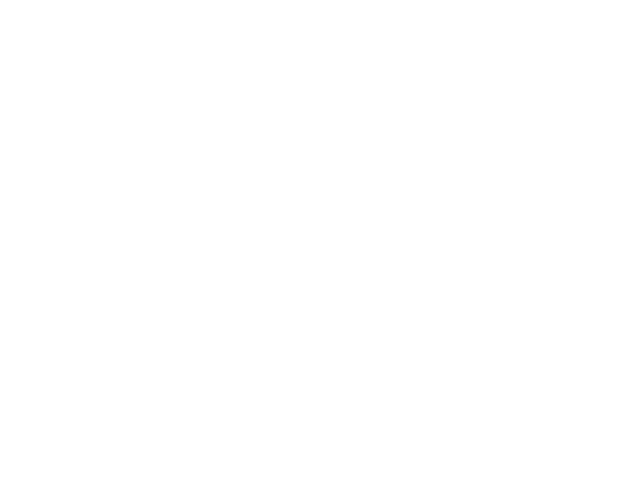

Text(0.5, 1.0, 'GAMMA-EM - First Generation')

In [30]:
#1st gen plot
%matplotlib notebook
j = 3462
plt.errorbar(np.log10(gal_Mstar_test_2[j][:-1]), gal_FeH_mean_test_2[j][:-1], fmt='o',color ='#5B6870', label='GAMMA Sub-trees')
plt.errorbar(np.log10(gal_Mstar_test_2[j][-1]), gal_FeH_mean_test_2[j][-1], fmt='o', color = '#B46012',label='GAMMA Host-tree')
plt.errorbar(log_em_Mstar_pred[j][:-1], em_FeH_mean_pred[j][:-1], xerr = 1.96*log_em_Mstar_pred_std[j][:-1], yerr=1.96*em_FeH_mean_pred_std[j][:-1], fmt='o', color = '#6E99B4', label='Emulated Sub-trees')
plt.errorbar(log_em_Mstar_pred[j][-1], em_FeH_mean_pred[j][-1], xerr = 1.96*log_em_Mstar_pred_std[j][-1], yerr=1.96*em_FeH_mean_pred_std[j][-1], fmt='o', color = '#FF9B1A', label='Emulated Host-tree')
plt.legend(loc='lower right')
#plt.xscale('log')
plt.xlabel('Stellar Mass - log([M$_\odot$])', ha='center', va='center')
plt.ylabel('Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
plt.title('GAMMA-EM - First Generation')
#plt.legend(bbox_to_anchor=(-2.5,4.04,3,1), loc="lower left",
               # mode="expand", borderaxespad=0, ncol=2)

In [31]:
print(np.power(10,log_em_Mstar_pred_2[j]))

[1.03020886e+08 1.68183056e+06 5.92960759e+05 2.23635736e+06
 1.75196020e+06 3.30611153e+06 7.54867221e+08 7.22430694e+06
 6.79459026e+07 4.83880283e+04 6.72384629e+06 3.87325132e+07
 8.25232400e+07 6.54272410e+05 4.09460119e+07 1.04666601e+06
 1.20130647e+07 1.85194978e+06 6.25155536e+06 7.80524780e+07
 8.19667643e+04 8.80684968e+10]


<IPython.core.display.Javascript object>


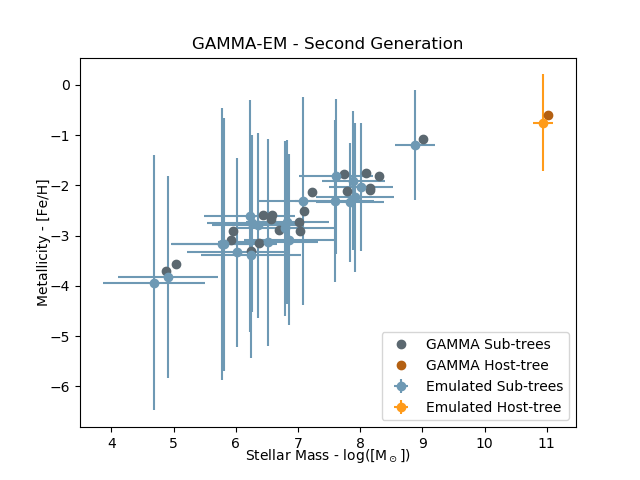

Text(0.5, 1.0, 'GAMMA-EM - Second Generation')

In [32]:
%matplotlib notebook
j = 3462
plt.errorbar(np.log10(gal_Mstar_test_2[j][:-1]), gal_FeH_mean_test_2[j][:-1], fmt='o',color ='#5B6870', label='GAMMA Sub-trees')
plt.errorbar(np.log10(gal_Mstar_test_2[j][-1]), gal_FeH_mean_test_2[j][-1], fmt='o', color = '#B46012',label='GAMMA Host-tree')
plt.errorbar(log_em_Mstar_pred_2[j][:-1], em_FeH_mean_pred_2[j][:-1], xerr = 1.96*log_em_Mstar_pred_std[j][:-1], yerr=1.96*em_FeH_mean_pred_std[j][:-1], fmt='o', color = '#6E99B4', label='Emulated Sub-trees')
plt.errorbar(log_em_Mstar_pred_2[j][-1], em_FeH_mean_pred_2[j][-1], xerr = 1.96*log_em_Mstar_pred_std[j][-1], yerr=1.96*em_FeH_mean_pred_std[j][-1], fmt='o', color = '#FF9B1A', label='Emulated Host-tree')
plt.legend(loc='lower right')
#plt.xscale('log')
plt.xlabel('Stellar Mass - log([M$_\odot$])', ha='center', va='center')
plt.ylabel('Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
plt.title('GAMMA-EM - Second Generation')
#plt.legend(bbox_to_anchor=(-2.5,4.04,3,1), loc="lower left",
               # mode="expand", borderaxespad=0, ncol=2)

## 3rd generation of emulator

In [ ]:
em_combo_std = log_em_Mstar_pred_std_2*em_FeH_mean_pred_std_2 #combined standard deviation, equally weighted between outputs

var_index = np.arange(0, 10000, 1).reshape(10000,1) #index count of the sample
indexed_combo_std = np.append(em_combo_std, var_index, axis = 1) #puts an in-array index of standard deviation results matching each sample parameter set
indexed_emsp = np.append(emsp_test_2, var_index, axis = 1) #puts an in-array index of each sample parameter set

top_index = np.zeros([22, 15]) #creates an array to be filled with the set of indexes that are associated with the 75 highest standard deviations in the test sample set

for i in range(len(indexed_combo_std[0])-1):
    x = indexed_combo_std[indexed_combo_std[:,i].argsort()] #sorts the given column 
    top_index[i] = x[-15:,-1].T #gets the largest combined std dev in each column
        
top, counts = np.unique(top_index, return_counts=True) #top is the array of the row index of emsp_test points that need to be added to the emulator

#points to add to the training data
emsp_train_adds = np.zeros([len(top), len(emsp_test_2[0])]) 
gal_Mstar_train_adds = np.zeros([len(top), len(gal_Mstar_test_2[0])])
gal_FeH_mean_train_adds = np.zeros([len(top), len(gal_FeH_mean_test_2[0])])

#selecting the training data from the original test set
for i in range(len(top)):
    index = int(top[i])
    emsp_train_adds[i] = emsp_test_2[index]
    gal_Mstar_train_adds[i] = gal_Mstar_test_2[index]
    gal_FeH_mean_train_adds[i] = gal_FeH_mean_test_2[index]

#add training points
emsp_train_3 = np.append(emsp_train_2, emsp_train_adds, axis = 0)
gal_Mstar_train_3 = np.append(gal_Mstar_train_2, gal_Mstar_train_adds, axis = 0)
gal_FeH_mean_train_3 = np.append(gal_FeH_mean_train_2, gal_FeH_mean_train_adds, axis = 0)

In [ ]:
#import new set of test points
emsp_test_3 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\em_sample_points10000_3.npy")
gal_Mstar_test_3 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_Mstar_10000_3.npy")
gal_FeH_mean_test_3 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_mean_10000_3.npy")
gal_FeH_std_test_3 = np.load(r"C:\Users\carli\Documents\Astrophysics General\iCER ACRES\GAMMA-EM\sample_sets\gal_FeH_std_10000_3.npy")

In [ ]:
sigma_train = np.zeros(len(gal_Mstar_train[0])) 
em_Mstar = []
log_em_Mstar_pred = np.zeros([len(gal_Mstar_test_3),len(gal_Mstar_test_3[0])])
log_em_Mstar_pred_std = np.zeros([len(gal_Mstar_test_3),len(gal_Mstar_test_3[0])])
log_gal_Mstar_train = np.log10(gal_Mstar_train)

#Stellar mass emulators
for i in range(len(log_gal_Mstar_train[0])):
    sigma_train[i] = np.log10(np.std(gal_Mstar_train[:,i]))
    #print(sigma_train[i])
    kern = C(sigma_train[i]**2) * RBF() * Matern() + WhiteKernel() 
    em_Mstar.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_Mstar[i].fit(emsp_train,log_gal_Mstar_train[:,i])
    #print(i)
    log_em_Mstar_pred[:,i], log_em_Mstar_pred_std[:,i] = em_Mstar[i].predict(emsp_test_3, return_std = True)

In [ ]:
sigma_train = np.zeros(len(gal_FeH_mean_train[0]))
em_FeH_mean = []
em_FeH_mean_pred = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
em_FeH_mean_pred_std = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
#print(gal_FeH_mean_train[:,i].shape)

#Metallicity emulators                          
for i in range(len(gal_FeH_mean_train[0])):
    sigma_train[i] = np.std(gal_FeH_mean_train[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train[i]**2) * RBF() * PairwiseKernel()
    em_FeH_mean.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_FeH_mean[i].fit(emsp_train,gal_FeH_mean_train[:,i])
    em_FeH_mean_pred[:,i], em_FeH_mean_pred_std[:,i] = em_FeH_mean[i].predict(emsp_test_3, return_std = True)

In [ ]:
sigma_train_2 = np.zeros(len(gal_Mstar_train_2[0])) 
em_Mstar_2 = []
log_em_Mstar_pred_2 = np.zeros([len(gal_Mstar_test_2),len(gal_Mstar_test_2[0])])
log_em_Mstar_pred_std_2 = np.zeros([len(gal_Mstar_test_2),len(gal_Mstar_test_2[0])])
log_gal_Mstar_train_2 = np.log10(gal_Mstar_train_2)
#print(log_gal_Mstar_train_2)

#Stellar mass emulators
for i in range(len(gal_Mstar_train_2[0])):
    sigma_train_2[i] = np.log10(np.std(gal_Mstar_train_2[:,i]))
    #print(sigma_train[i])
    kern = C(sigma_train_2[i]**2) * RBF() * Matern() + WhiteKernel()
    em_Mstar_2.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_Mstar_2[i].fit(emsp_train_2,log_gal_Mstar_train_2[:,i])
    log_em_Mstar_pred_2[:,i], log_em_Mstar_pred_std_2[:,i] = em_Mstar_2[i].predict(emsp_test_3, return_std = True)

In [ ]:
sigma_train_2 = np.zeros(len(gal_FeH_mean_train_2[0])) 
em_FeH_mean_2 = []
em_FeH_mean_pred_2 = np.zeros([len(gal_FeH_mean_test_2),len(gal_FeH_mean_test_2[0])])
em_FeH_mean_pred_std_2 = np.zeros([len(gal_FeH_mean_test_2),len(gal_FeH_mean_test_2[0])])

#Stellar mass emulators
for i in range(len(gal_FeH_mean_train_2[0])):
    sigma_train_2[i] = np.std(gal_FeH_mean_train_2[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train_2[i]**2) * RBF() * PairwiseKernel()
    em_FeH_mean_2.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_FeH_mean_2[i].fit(emsp_train_2,gal_FeH_mean_train_2[:,i])
    em_FeH_mean_pred_2[:,i], em_FeH_mean_pred_std_2[:,i] = em_FeH_mean_2[i].predict(emsp_test_3, return_std = True)

In [ ]:
sigma_train_3 = np.zeros(len(gal_Mstar_train_3[0])) 
em_Mstar_3 = []
log_em_Mstar_pred_3 = np.zeros([len(gal_Mstar_test_3),len(gal_Mstar_test_3[0])])
log_em_Mstar_pred_std_3 = np.zeros([len(gal_Mstar_test_3),len(gal_Mstar_test_3[0])])
log_gal_Mstar_train_3 = np.log10(gal_Mstar_train_3)
#print(log_gal_Mstar_train_3)

#Stellar mass emulators
for i in range(len(gal_Mstar_train_3[0])):
    sigma_train_3[i] = np.log10(np.std(gal_Mstar_train_3[:,i]))
    #print(sigma_train[i])
    kern = C(sigma_train_3[i]**3) * RBF() * Matern() + WhiteKernel()
    em_Mstar_3.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_Mstar_3[i].fit(emsp_train_3,log_gal_Mstar_train_3[:,i])
    log_em_Mstar_pred_3[:,i], log_em_Mstar_pred_std_3[:,i] = em_Mstar_3[i].predict(emsp_test_3, return_std = True)

In [ ]:
sigma_train_3 = np.zeros(len(gal_FeH_mean_train_3[0])) 
em_FeH_mean_3 = []
em_FeH_mean_pred_3 = np.zeros([len(gal_FeH_mean_test_3),len(gal_FeH_mean_test_3[0])])
em_FeH_mean_pred_std_3 = np.zeros([len(gal_FeH_mean_test_3),len(gal_FeH_mean_test_3[0])])

#Stellar mass emulators
for i in range(len(gal_FeH_mean_train_3[0])):
    sigma_train_3[i] = np.std(gal_FeH_mean_train_3[:,i])
    #print(sigma_train[i])
    kern = C(sigma_train_3[i]**2) * RBF() * PairwiseKernel()
    em_FeH_mean_3.append(GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=1))
    em_FeH_mean_3[i].fit(emsp_train_3,gal_FeH_mean_train_3[:,i])
    em_FeH_mean_pred_3[:,i], em_FeH_mean_pred_std_3[:,i] = em_FeH_mean_3[i].predict(emsp_test_3, return_std = True)

In [ ]:
r_2_1 = 0
for i in range((len(gal_Mstar_train_2[0])-1)):
    #print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred[:,i]))) #Test R^2
    r_2_1 += r2_score(np.log10(gal_Mstar_test_3[:,i]), log_em_Mstar_pred_2[:,i])

r_2_1 = r_2_1 / (len(gal_Mstar_train_3[0])-1)

r_2_2 = 0
for i in range((len(gal_Mstar_train_2[0])-1)):
    #print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(np.log10(gal_Mstar_test_2[:,i]), log_em_Mstar_pred_2[:,i]))) #Test R^2
    r_2_2 += r2_score(np.log10(gal_Mstar_test_3[:,i]), log_em_Mstar_pred_3[:,i])

r_2_2 = r_2_2 / (len(gal_Mstar_train_3[0])-1)

print("R^2 of 1st gen: " + str(r_2_1))
print("R^2 of 2nd gen: " + str(r_2_2))

In [ ]:
#R^2 check against 1st gen emulator
for i in range(len(gal_FeH_mean_train_2[0])):
    #print("1. Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_3[:,i], np.power(10,em_FeH_mean_pred[:,i])))+ ", LML:" + str(em_FeH_mean[i].log_marginal_likelihood())) #Test R^2
    print("2. Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_3[:,i], em_FeH_mean_pred_2[:,i]))+ ", LML:" + str(em_FeH_mean_2[i].log_marginal_likelihood())) #Test R^2
    print("3. Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_3[:,i], em_FeH_mean_pred_3[:,i]))+ ", LML:" + str(em_FeH_mean_3[i].log_marginal_likelihood())) #Test R^2
    #print("2. Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean_2[i].score(emsp_test_2,np.log10(gal_FeH_mean_test_2[:,i])))+ ", LML:" + str(em_FeH_mean_2[i].log_marginal_likelihood())) #Test R^2
    #print("Test sample " + str(i) + " : R^2 - " + str(em_FeH_mean_2[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i])- em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i])))
    #print("Test sample " + str(i) + " : LML difference (Bayes factor) - " + str(em_FeH_mean_2[i].log_marginal_likelihood()-em_FeH_mean[i].log_marginal_likelihood()))

In [ ]:
#R^2 check against 1st gen emulator
#for i in range(len(gal_FeH_mean_train_2[0])):
    #print("1. Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean[i].score(emsp_test, gal_FeH_mean_test[:,i]))+ ", LML:" + str(em_FeH_mean[i].log_marginal_likelihood())) #Test R^2
    #print("2. Test sample " + str(i) + " : R^2 - "+ str(em_FeH_mean_2[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i]))+ ", LML:" + str(em_FeH_mean_2[i].log_marginal_likelihood())) #Test R^2
    #print("Test sample " + str(i) + " : R^2 - " + str(em_FeH_mean_2[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i])- em_FeH_mean[i].score(emsp_test_2, gal_FeH_mean_test_2[:,i])))
    #print("Test sample " + str(i) + " : LML difference (Bayes factor) - " + str(em_FeH_mean[i].log_marginal_likelihood()-em_FeH_mean_2[i].log_marginal_likelihood()))
    
r_2_1 = 0
for i in range((len(gal_FeH_mean_train_2[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_3[:,i], em_FeH_mean_pred_2[:,i]))) #Test R^2
    r_2_1 += r2_score(gal_FeH_mean_test_3[:,i], em_FeH_mean_pred_2[:,i])

r_2_1 = r_2_1 / (len(gal_FeH_mean_train_3[0])-1)

r_2_2 = 0
for i in range((len(gal_FeH_mean_train_2[0])-1)):
    print("Test sample " + str(i) + " : R^2 - "+ str(r2_score(gal_FeH_mean_test_3[:,i], em_FeH_mean_pred_3[:,i]))) #Test R^2
    r_2_2 += r2_score(gal_FeH_mean_test_3[:,i], em_FeH_mean_pred_3[:,i])
r_2_2 = r_2_2 / (len(gal_FeH_mean_train_3[0])-1)

print("R^2 of 1st gen: " + str(r_2_1))
print("R^2 of 2nd gen: " + str(r_2_2))

In [ ]:
#3rd Gen plot
j = 4650
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')
for i in range(4):
    for k in range(5):
        ax[i, k].errorbar(np.log10(gal_Mstar_test_3[j][:-1]), gal_FeH_mean_test_3[j][:-1], fmt='o',color ='steelblue', label='GAMMA Sub-trees')
        ax[i, k].errorbar(np.log10(gal_Mstar_test_3[j][-1]), gal_FeH_mean_test_3[j][-1], fmt='o', color = 'firebrick',label='GAMMA Host-tree')
        ax[i, k].errorbar(log_em_Mstar_pred_3[j][:-1], em_FeH_mean_pred_3[j][:-1], xerr = 1.96*log_em_Mstar_pred_std_3[j][:-1], yerr=1.96*em_FeH_mean_pred_std_3[j][:-1], fmt='o', color = 'goldenrod', label='Emulated Sub-trees')
        ax[i, k].errorbar(log_em_Mstar_pred_3[j][-1], em_FeH_mean_pred_3[j][-1], xerr = 1.96*log_em_Mstar_pred_std_3[j][-1], yerr=1.96*em_FeH_mean_pred_std_3[j][-1], fmt='o', color = 'lightcoral', label='Emulated Host-tree')
        ax[i, k].set_xscale('log')
        j += 1


plt.legend(loc='right')
#plt.xscale('log')
fig.text(0.5, 0.03, 'Stellar Mass - log[M$_\odot$]', ha='center', va='center')
fig.text(0.06, 0.5, 'Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('GAMMA-EM - Third Generation')
plt.legend(bbox_to_anchor=(-3.5,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

In [ ]:
#1st gen plot

j = 0
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')
for i in range(4):
    for k in range(5):
        ax[i, k].errorbar(np.log10(gal_Mstar_test_3[j][:-1]), gal_FeH_mean_test_3[j][:-1], fmt='o',color ='steelblue', label='Dwarf Galaxy (GAMMA)')
        ax[i, k].errorbar(np.log10(gal_Mstar_test_3[j][-1]), gal_FeH_mean_test_3[j][-1], fmt='o', color = 'firebrick', label='Host Galaxy (GAMMA)')
        ax[i, k].errorbar(log_em_Mstar_pred[j][:-1], em_FeH_mean_pred[j][:-1], xerr = 1.96*log_em_Mstar_pred_std[j][:-1], yerr=1.96*em_FeH_mean_pred_std[j][:-1], fmt='o', color = 'goldenrod', label= 'Dwarf Galaxies (Emulator)')
        ax[i, k].errorbar(log_em_Mstar_pred[j][-1], em_FeH_mean_pred[j][-1], xerr = 1.96*log_em_Mstar_pred_std[j][-1], yerr=1.96*em_FeH_mean_pred_std[j][-1], fmt='o', color = 'lightcoral', label= 'Host Galaxy (Emulator)')
        ax[i, k].set_xlim(5.0,11.7)
        ax[i, k].set_ylim(-4.5,1)
        j += 1


plt.legend(loc='right')
#plt.xscale('log')
fig.text(0.5, 0.03, 'Stellar Mass - log([M$_\odot$])', ha='center', va='center')
fig.text(0.06, 0.5, 'Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('GAMMA-EM - First Generation Emulator')
plt.legend(bbox_to_anchor=(-3.0,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

In [ ]:
#2nd Gen plot
j = 120
fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')
for i in range(4):
    for k in range(5):
        ax[i, k].errorbar(np.log10(gal_Mstar_test_3[j][:-1]), gal_FeH_mean_test_3[j][:-1], fmt='o',color ='steelblue', label='Dwarf Galaxy (GAMMA)')
        ax[i, k].errorbar(np.log10(gal_Mstar_test_3[j][-1]), gal_FeH_mean_test_3[j][-1], fmt='o', color = 'firebrick', label='Host Galaxy (GAMMA)')
        ax[i, k].errorbar(log_em_Mstar_pred_2[j][:-1], em_FeH_mean_pred_2[j][:-1], xerr = 1.96*log_em_Mstar_pred_std_2[j][:-1], yerr=1.96*em_FeH_mean_pred_std_2[j][:-1], fmt='o', color = 'goldenrod', label='Dwarf Galaxies (Emulator)')
        ax[i, k].errorbar(log_em_Mstar_pred_2[j][-1], em_FeH_mean_pred_2[j][-1], xerr = 1.96*log_em_Mstar_pred_std_2[j][-1], yerr=1.96*em_FeH_mean_pred_std_2[j][-1], fmt='o', color = 'lightcoral', label='Host Galaxy (Emulator)')
        ax[i, k].set_xlim(5.0,11.7)
        ax[i, k].set_ylim(-4.5,1)
        j += 1


plt.legend(loc='right')
#plt.xscale('log')
fig.text(0.5, 0.03, 'Stellar Mass - log[M$_\odot$]', ha='center', va='center')
fig.text(0.06, 0.5, 'Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('GAMMA-EM - Second Generation Emulator')
plt.legend(bbox_to_anchor=(-3.0,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

In [ ]:
k = 93
print(emsp_test_3[k])
sample_1 = np.array(emsp_test_3[k])
sample = np.array(sample_1)
x = np.zeros([len(em_Mstar_2)])
y = np.zeros([len(em_Mstar_2)])
for i in range(len(em_Mstar_2)):
    x[i] = em_Mstar_2[i].predict(sample.reshape(1,-1))
    y[i] = em_FeH_mean_2[i].predict(sample.reshape(1,-1))

In [ ]:
%matplotlib notebook

plt.errorbar(x[-1],y[-1], fmt='o', color = "orange", label = "Host Galaxy")
plt.errorbar(x[:-1],y[:-1], fmt='o', color = "skyblue", label = "Dwarf Galaxies")
plt.errorbar(log_em_Mstar_pred_2[k][:-1], em_FeH_mean_pred_2[k][:-1], xerr = 1.96*log_em_Mstar_pred_std_2[j][:-1], yerr=1.96*em_FeH_mean_pred_std_2[j][:-1], fmt='o', color = 'goldenrod', label='Dwarf Galaxies (Emulator)')
plt.errorbar(log_em_Mstar_pred_2[k][-1], em_FeH_mean_pred_2[k][-1], xerr = 1.96*log_em_Mstar_pred_std_2[j][-1], yerr=1.96*em_FeH_mean_pred_std_2[j][-1], fmt='o', color = 'lightcoral', label='Host Galaxy (Emulator)')

In [ ]:
from joblib import load
import numpy as np

em_Mstar = load("C:/Users/carli/Documents/Astrophysics General/iCER ACRES/stellar_mass_emulator.joblib")
em_FeH = load("C:/Users/carli/Documents/Astrophysics General/iCER ACRES/metallicity_emulator.joblib")

#load in input testing data
emsp_test = np.load(r"C:/Users/carli/Documents/Astrophysics General/iCER ACRES/GAMMA-EM/sample_sets/em_sample_points10000.npy") #set of sample parameter
#load in output testing data
gal_Mstar_test = np.load(r"C:/Users/carli/Documents/Astrophysics General/iCER ACRES/GAMMA-EM/sample_sets/gal_Mstar_10000.npy")
gal_FeH_mean_test = np.load(r"C:/Users/carli/Documents/Astrophysics General/iCER ACRES/GAMMA-EM/sample_sets/gal_FeH_mean_10000.npy")
gal_FeH_std_test = np.load(r"C:/Users/carli/Documents/Astrophysics General/iCER ACRES/GAMMA-EM/sample_sets/gal_FeH_std_10000.npy")

log_em_Mstar_pred = np.zeros([len(gal_Mstar_test),len(gal_Mstar_test[0])])
log_em_Mstar_pred_std = np.zeros([len(gal_Mstar_test),len(gal_Mstar_test[0])])
em_FeH_mean_pred = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])
em_FeH_mean_pred_std = np.zeros([len(gal_FeH_mean_test),len(gal_FeH_mean_test[0])])

for i in range(len(em_Mstar)):
    log_em_Mstar_pred[:,i], log_em_Mstar_pred_std[:,i] = em_Mstar[i].predict(emsp_test, return_std = True)
    em_FeH_mean_pred[:,i], em_FeH_mean_pred_std[:,i] = em_FeH[i].predict(emsp_test, return_std = True)

fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')
j=0
for i in range(4):
    for k in range(5):
        ax[i, k].errorbar(np.log10(gal_Mstar_test[j][:-1]), gal_FeH_mean_test[j][:-1], fmt='o',color ='steelblue', label='Dwarf Galaxy (GAMMA)')
        ax[i, k].errorbar(np.log10(gal_Mstar_test[j][-1]), gal_FeH_mean_test[j][-1], fmt='o', color = 'firebrick', label='Host Galaxy (GAMMA)')
        ax[i, k].errorbar(log_em_Mstar_pred[j][:-1], em_FeH_mean_pred[j][:-1], xerr = 1.96*log_em_Mstar_pred_std[j][:-1], yerr=1.96*em_FeH_mean_pred_std[j][:-1], fmt='o', color = 'goldenrod', label= 'Dwarf Galaxies (Emulator)')
        ax[i, k].errorbar(log_em_Mstar_pred[j][-1], em_FeH_mean_pred[j][-1], xerr = 1.96*log_em_Mstar_pred_std[j][-1], yerr=1.96*em_FeH_mean_pred_std[j][-1], fmt='o', color = 'lightcoral', label= 'Host Galaxy (Emulator)')
        ax[i, k].set_xlim(5.0,11.7)
        ax[i, k].set_ylim(-4.5,1)
        j += 1


plt.legend(loc='right')
#plt.xscale('log')
fig.text(0.5, 0.03, 'Stellar Mass - log([M$_/odot$])', ha='center', va='center')
fig.text(0.06, 0.5, 'Metallicity - [Fe/H]', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace = 0)
fig.suptitle('GAMMA-EM')
plt.legend(bbox_to_anchor=(-3.0,4.04,3,1), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)